## In this notebook, we will look at real stock prices for Tesla Stock from 2022 and using black scholes, we will price certian options and then proceed with delta hedging and analyse the results for the following cases:

1) Buy call and short stock
2) Sell call and long stock
3) Buy put and long stock
4) Sell put and short stock

# Black Scholes Model for pricing Options

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

## d1 and d2 calculation

In [2]:
def d1(S,K,r,T,sigma):
    val=(np.log(S/K) + (r+ 0.5 * sigma **2)*T)/ (sigma* np.sqrt(T))
    return val
def d2(S,K,r,T,sigma):
    val=(np.log(S/K) + (r- 0.5*sigma **2)*T)/(sigma * np.sqrt(T))
    return val

## Call and Put Prices

In [3]:
def call_price(S,K,r,T,sigma):
    d1_val=d1(S,K,r,T,sigma)
    d2_val=d2(S,K,r,T,sigma)
    price= S* norm.cdf(d1_val)-K* np.exp(-r * T) *norm.cdf(d2_val)
    return price
def put_price(S,K,r,T,sigma):
    d1_val=d1(S,K,r,T,sigma)
    d2_val=d2(S,K,r,T,sigma)
    price= K* np.exp(-r*T) * norm.cdf(-d2_val) - S* norm.cdf(-d1_val)
    return price

## The Greeks
-> Delta is the rate of change of an option's price with respect to the change in the price of the underlying asset. Δ= ∂V/∂S

-> Gamma is the rate of change of Delta with respect to the change in the underlying asset's price. Γ=∂S2/∂V2 = ∂Δ/∂S

-> Vega is the rate of change of an option's price with respect to a 1% change in implied volatility of the underlying asset. Vega= ∂V/∂σ

-> Theta measures the time decay of an option — how much the option's value decreases as one day passes, assuming all else remains constant.Θ= ∂V/∂t

In [4]:
def delta(S,K,r,T,sigma,option_type='call'):
    d1_val=d1(S,K,r,T,sigma)
    if option_type=='call':
        delta_val= norm.cdf(d1_val)
    else:
        delta_val= -norm.cdf(-d1_val)
    return delta_val

In [5]:
def gamma(S,K,r,T,sigma):
    d1_val=d1(S,K,r,T,sigma)
    gamma_val=norm.pdf(d1_val) / (S* sigma * np.sqrt(T))
    return gamma_val

In [6]:
def vega(S,K,r,T,sigma):
    d1_val=d1(S,K,r,T,sigma)
    vega_val=S*norm.pdf(d1_val) * np.sqrt(T)
    return vega_val

In [7]:
def theta(S,K,r,T,sigma,option_type='call'):
    d1_val=d1(S,K,r,T,sigma)
    d2_val=d2(S,K,r,T,sigma)
    term1=-(S*norm.pdf(d1_val)*sigma) / (2*np.sqrt(T))
    if option_type=='call':
        term2= -r*K * np.exp(-r*T)*norm.cdf(d2_val)
        return term1+term2
    else:
        term2= r*K * np.exp(-r*T)*norm.cdf(d2_val)
        return term1+term2

In [8]:
def bs_price(S, K, r, T, sigma, option_type='call'):
    if option_type == 'call':
        return call_price(S, K, r, T, sigma)
    else:
        return put_price(S, K, r, T, sigma)

## Calculation of Theoretical Price and Mispricing

In [9]:
def compute_theoretical_and_mispricing(row,r):
    S = row['S']
    K = row['K']
    T = row['T']
    sigma = row['iv']
    market_price = row['market_price']
    option_type = row['option_type']
    theo_price = bs_price(S, K, r, T, sigma, option_type)
    mispricing = theo_price - market_price
    return pd.Series([theo_price, mispricing], index=['theo_price', 'mispricing'])

## Stock data

In [10]:
data=pd.read_csv("TSLA.csv")
data=data.iloc[::-1].reset_index(drop=True)
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2022-01-03,399.93,382.58,400.36,378.68,104.69M,13.53%
1,2022-01-04,383.20,396.52,402.67,374.35,100.25M,-4.18%
2,2022-01-05,362.71,382.22,390.11,360.34,80.12M,-5.35%
3,2022-01-06,354.90,359.00,362.67,340.17,90.34M,-2.15%
4,2022-01-07,342.32,360.12,360.31,336.67,84.16M,-3.54%


# Buy Call and Short Stock

Option Parameters

In [11]:
S = 399
K = 415
T = 1.24
sigma = 0.2
market_price= 25
option_type='call'
r=0.05

In [12]:
max_row=pd.DataFrame(columns=['Date','S','K','T','iv','market_price','option_type'])
max_row.loc[0] = ['2022-01-03', S, K, T, sigma,market_price,option_type]
theo_price, misprice=compute_theoretical_and_mispricing(max_row.iloc[0],0.05)
max_row['theo_price']=theo_price
max_row['misprice']=misprice
max_row

,Date,S,K,T,iv,market_price,option_type,theo_price,misprice
0,2022-01-03,399,415,1.24,0.2,25,call,39.635592,14.635592


Positive mispricing shows, undervalued option so we buy it

In [13]:
from datetime import timedelta
option_date = pd.to_datetime(max_row['Date'])
days_to_expiry = int(max_row['T'] * 365)
expiry_date = option_date + timedelta(days=days_to_expiry)
expiry_date

0   2023-03-31
Name: Date, dtype: datetime64[ns]

In [14]:
option_type = 'call'
quantity = 100 
K = max_row['K'].iloc[0]
T0 = max_row['T'].iloc[0]
sigma = max_row['iv'].iloc[0]
entry_price = max_row['market_price'].iloc[0]
r = 0.05  # risk-free rate

# Stock data
stock_prices = data.copy().reset_index()
stock_prices = stock_prices.sort_values('Date')  # Ensure proper order
start_date = '2022-01-03'
end_date = '2023-03-31'
stock_prices = stock_prices[
    (stock_prices['Date'] >= start_date) &
    (stock_prices['Date'] <= end_date)
].copy()
expiry_date = pd.to_datetime('2023-03-31')
stock_prices['T'] = (expiry_date - stock_prices['Date']).dt.days / 365

# Portfolio tracking
cash_flows = []
stock_held = []
deltas = []
gammas = []
vegas = []
thetas = []
portfolio_values = []
option_values = []
cash = 0

# Day 0: Buy option, hedge delta
S0 = stock_prices.iloc[0]['Open']
delta0 = delta(S0, K, r, T0, sigma, option_type)
stock_qty = delta0 * quantity
cash = -entry_price * quantity + stock_qty * S0  

# Greeks
gamma0 = gamma(S0, K, r, T0, sigma)
vega0 = vega(S0, K, r, T0, sigma)
theta0 = theta(S0, K, r, T0, sigma, option_type)

# Option price
option_val = bs_price(S0, K, r, T0, sigma)

# Record
cash_flows.append(cash)
stock_held.append(stock_qty)
deltas.append(delta0)
gammas.append(gamma0)
vegas.append(vega0)
thetas.append(theta0)
option_values.append(option_val)
portfolio_values.append(option_val*quantity + cash + stock_qty * S0)

# Daily rebalancing
for i in range(1, len(stock_prices)):
    row = stock_prices.iloc[i]
    S = row['Open']
    T = row['T']
    new_delta = delta(S, K, r, T, sigma, option_type)
    target_stock = new_delta * quantity
    rebalance_qty = target_stock - stock_held[-1]
    diff = rebalance_qty * S
    cash += diff
    print(f"Day {i}: Previous stock holding = {stock_held[-1]:.2f}, New required = {target_stock:.2f}, "
          f"Rebalance Qty = {rebalance_qty:.2f}, Cash Change = {rebalance_qty * S:.2f}")

    # Greeks
    gamma_val = gamma(S, K, r, T, sigma)
    vega_val = vega(S, K, r, T, sigma)
    theta_val = theta(S, K, r, T, sigma, option_type)

    # Option price (Black-Scholes)
    option_val = bs_price(S, K, r, T, sigma)

    # Total portfolio value
    portfolio_val = option_val * quantity + target_stock * S + cash

    # Logs
    deltas.append(new_delta)
    gammas.append(gamma_val)
    vegas.append(vega_val)
    thetas.append(theta_val)
    option_values.append(option_val)
    stock_held.append(target_stock)
    cash_flows.append(cash)
    portfolio_values.append(portfolio_val)

# Final adjustment
final_price = stock_prices.iloc[-1]['Open']
final_position = stock_held[-1]
intrinsic_val = max(final_price - K, 0) * quantity
close_hedge = -final_position * final_price
cash += intrinsic_val + close_hedge
final_pnl = cash + intrinsic_val + close_hedge

print(f"\nFinal Adjustment: Stock closeout = {close_hedge:.2f}, Intrinsic Value = {intrinsic_val:.2f}")
print(f"Final Net P&L = {round(final_pnl, 2)}")

# DataFrame output
results = pd.DataFrame({
    'Date': stock_prices['Date'],
    'Stock_Price': stock_prices['Open'],
    'Delta': deltas,
    'Gamma': gammas,
    'Vega': vegas,
    'Theta': thetas,
    'Hedge_Position': stock_held,
    'Cash': cash_flows,
    'Option_Value': option_values,
    'Portfolio_Value': portfolio_values
})

Day 1: Previous stock holding = 50.98, New required = 57.31, Rebalance Qty = 6.33, Cash Change = 2509.04
Day 2: Previous stock holding = 57.31, New required = 50.72, Rebalance Qty = -6.58, Cash Change = -2516.34
Day 3: Previous stock holding = 50.72, New required = 39.54, Rebalance Qty = -11.18, Cash Change = -4014.53
Day 4: Previous stock holding = 39.54, New required = 40.04, Rebalance Qty = 0.50, Cash Change = 179.18
Day 5: Previous stock holding = 40.04, New required = 27.23, Rebalance Qty = -12.81, Cash Change = -4269.30
Day 6: Previous stock holding = 27.23, New required = 35.55, Rebalance Qty = 8.32, Cash Change = 2923.37
Day 7: Previous stock holding = 35.55, New required = 39.57, Rebalance Qty = 4.02, Cash Change = 1445.15
Day 8: Previous stock holding = 39.57, New required = 44.43, Rebalance Qty = 4.86, Cash Change = 1795.16
Day 9: Previous stock holding = 44.43, New required = 30.06, Rebalance Qty = -14.36, Cash Change = -4882.60
Day 10: Previous stock holding = 30.06, New r

In [15]:
def plot(data, column):
    plt.figure(figsize=(14,5))
    plt.plot(data[column])
    plt.title(column)
    plt.xlabel("Days")
    plt.grid()
    plt.show()

In [16]:
ls=['Stock_Price', 'Delta', 'Gamma', 'Vega', 'Theta','Hedge_Position', 'Cash', 'Option_Value', 'Portfolio_Value']

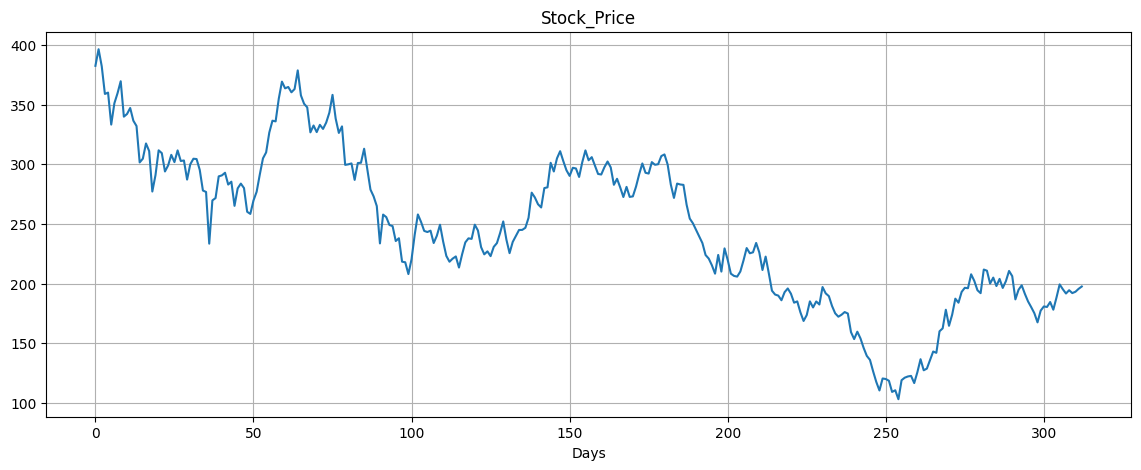

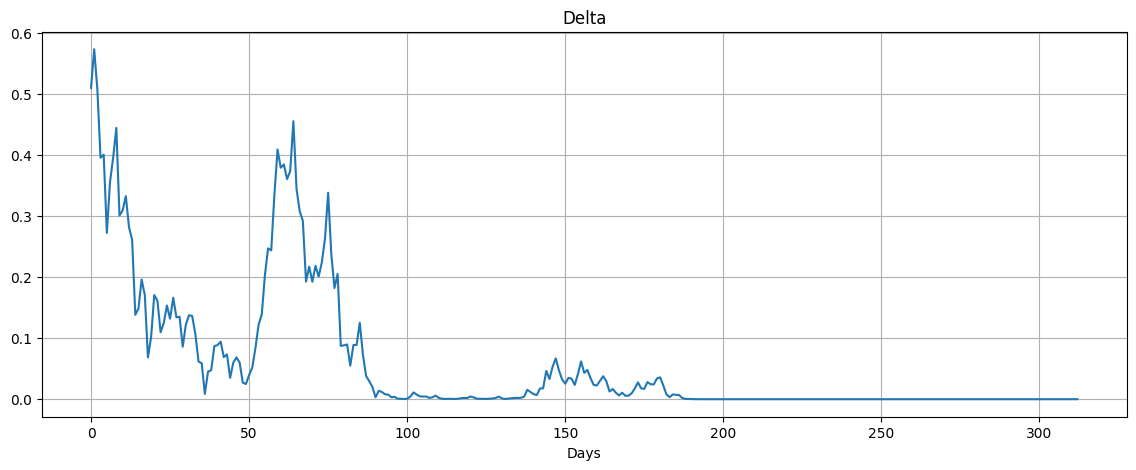

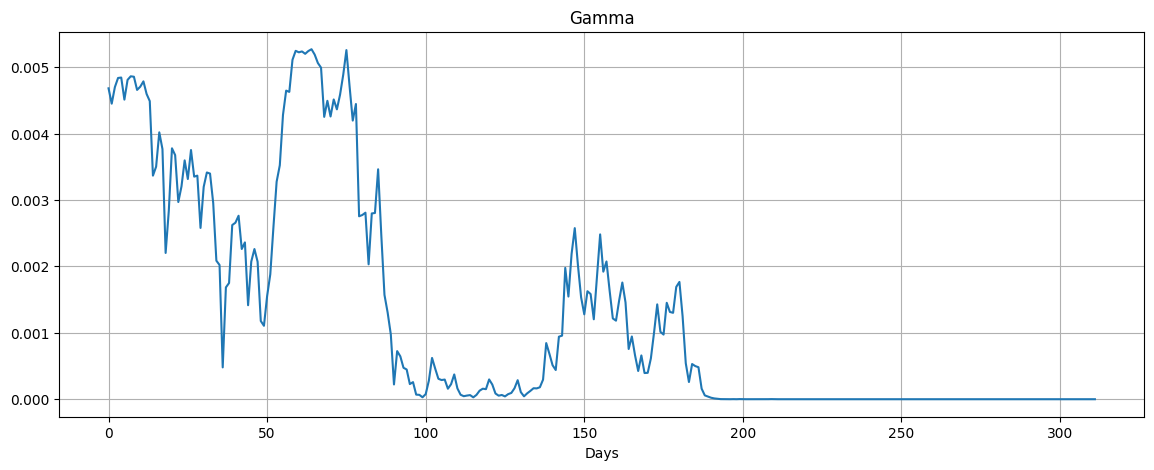

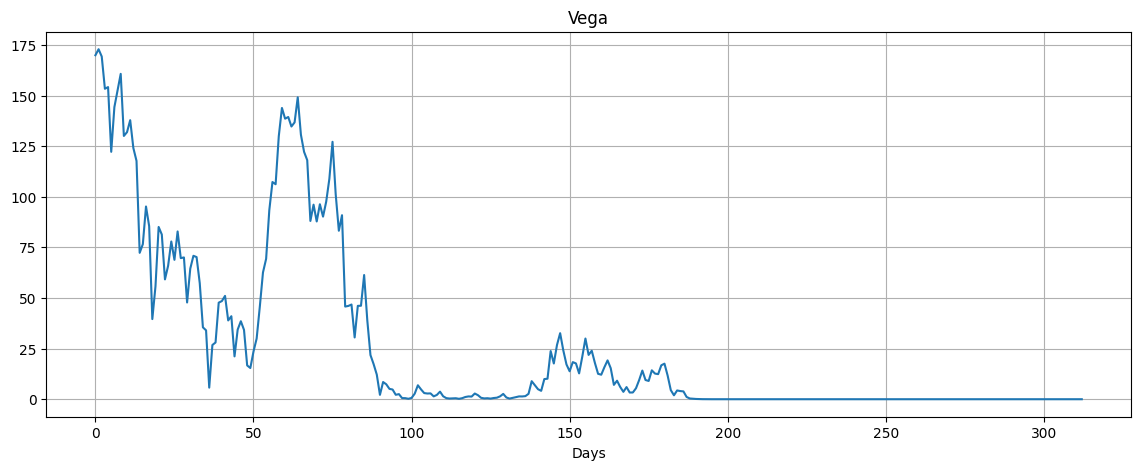

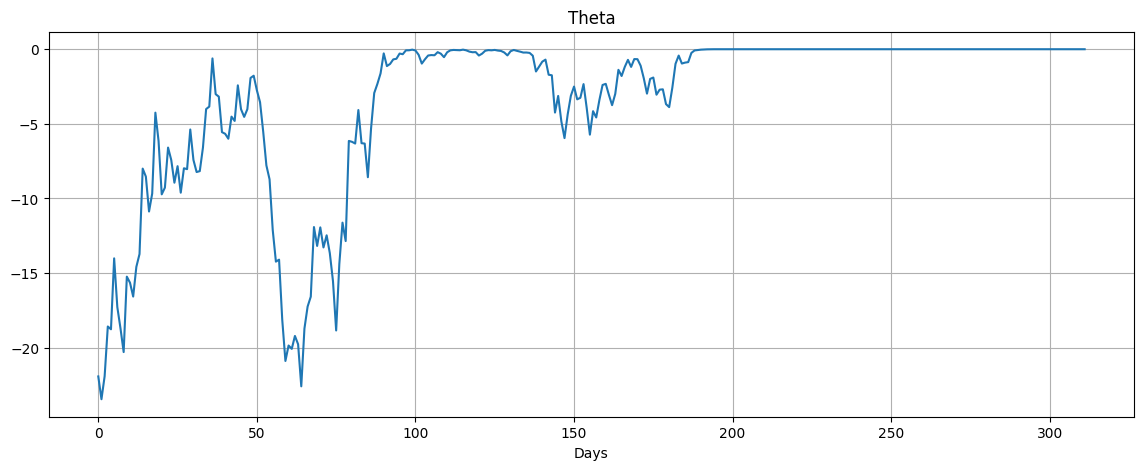

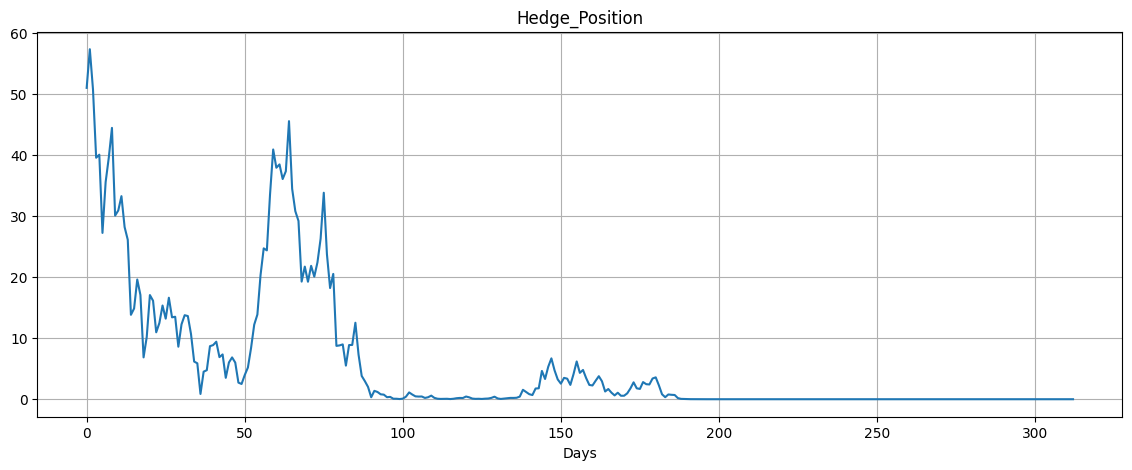

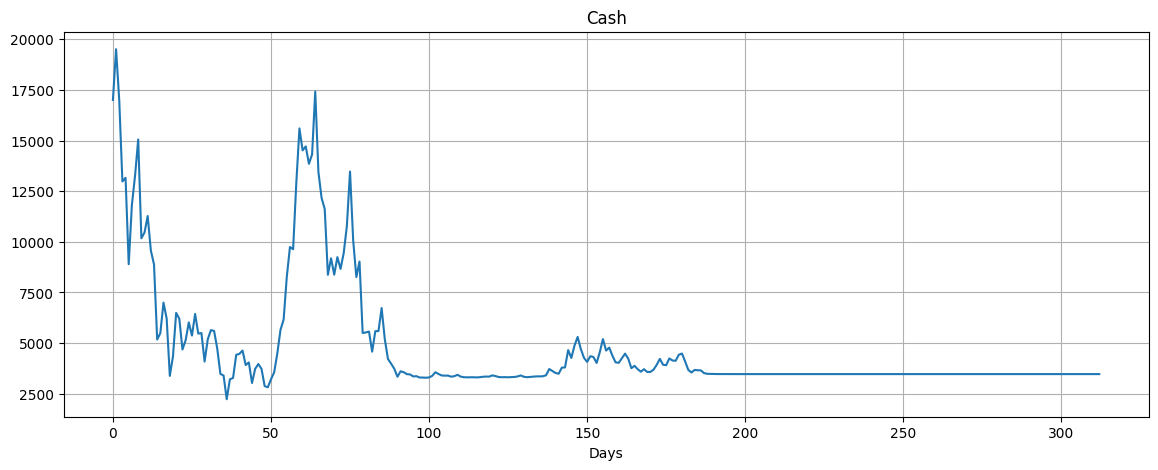

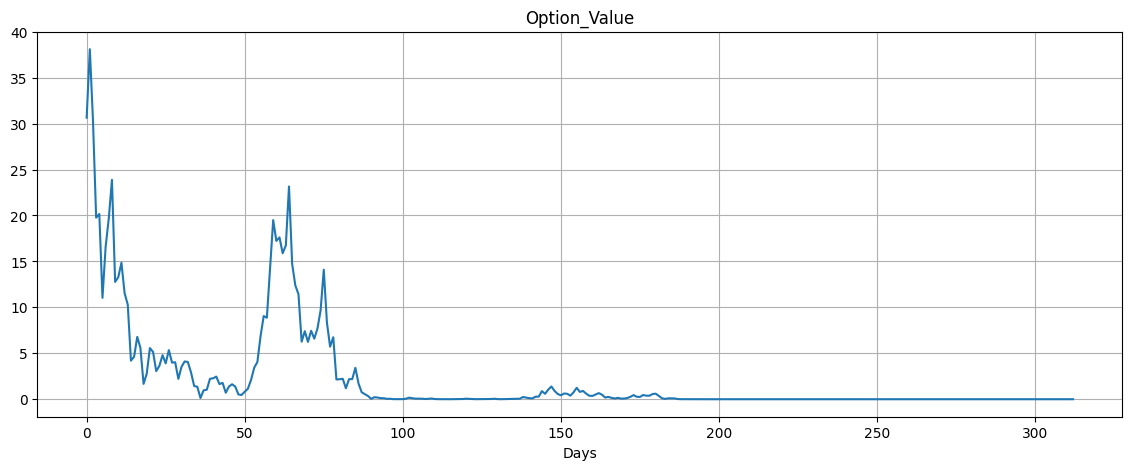

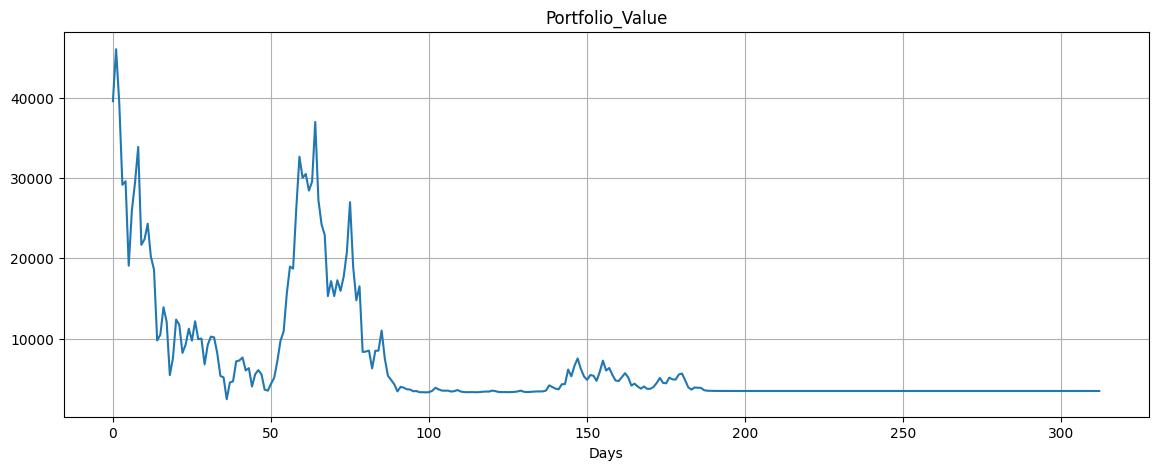

In [17]:
for i in ls:
    plot(results,i)

# Sell Call and Long Stock

Option Parameters

In [18]:
S = 399
K = 410
T = 0.95
sigma = 0.15
market_price= 50
option_type='call'

In [19]:
min_row=pd.DataFrame(columns=['Date','S','K','T','iv','market_price','option_type'])
min_row.loc[0] = ['2022-01-03', S, K, T, sigma,market_price,option_type]
theo_price, misprice=compute_theoretical_and_mispricing(min_row.iloc[0],0.05)
min_row['theo_price']=theo_price
min_row['misprice']=misprice
min_row

,Date,S,K,T,iv,market_price,option_type,theo_price,misprice
0,2022-01-03,399,410,0.95,0.15,50,call,27.248809,-22.751191


In [20]:
from datetime import timedelta
option_date = pd.to_datetime(min_row['Date'])
days_to_expiry = int(min_row['T'] * 365)
expiry_date = option_date + timedelta(days=days_to_expiry)
expiry_date

0   2022-12-15
Name: Date, dtype: datetime64[ns]

In [21]:
option_type = 'call'
quantity = 100 
K = min_row['K'].iloc[0]         
T0 = min_row['T'].iloc[0]        
sigma = min_row['iv'].iloc[0]    
entry_price = min_row['market_price'].iloc[0]  
r = 0.05    # Risk-free rate

# Stock data
stock_prices = data.copy().reset_index()
stock_prices = stock_prices.sort_values('Date')
start_date = '2022-01-03'
end_date = '2022-12-15'
stock_prices = stock_prices[
    (stock_prices['Date'] >= start_date) &
    (stock_prices['Date'] <= end_date)
].copy()
expiry_date = pd.to_datetime('2022-12-15')
stock_prices['T'] = (expiry_date - stock_prices['Date']).dt.days / 365

# Portfolio Tracking
cash_flows = []
stock_held = []
deltas = []
gammas = []
vegas = []
thetas = []
portfolio_values = []
option_values = []
cash = 0

# Day 0: Sell option, hedge delta
S0 = stock_prices.iloc[0]['Open']
delta0 = delta(S0, K, r, T0, sigma, option_type)
stock_qty = delta0 * quantity   # Long these many shares
cash = entry_price * quantity - stock_qty * S0  # Receive premium, pay for shares

# Greeks
gamma0 = gamma(S0, K, r, T0, sigma)
vega0 = vega(S0, K, r, T0, sigma)
theta0 = theta(S0, K, r, T0, sigma, option_type)

# Option price
option_val = bs_price(S0, K, r, T0, sigma)

# Record 
cash_flows.append(cash)
stock_held.append(stock_qty)
deltas.append(delta0)
gammas.append(gamma0)
vegas.append(vega0)
thetas.append(theta0)
option_values.append(-option_val)  
portfolio_values.append(-option_val*quantity + stock_qty * S0 + cash)

# Rebalancing each day
for i in range(1, len(stock_prices)):
    row = stock_prices.iloc[i]
    S = row['Open']
    T = row['T']
    new_delta = delta(S, K, r, T, sigma, option_type)
    target_stock = new_delta * quantity
    rebalance_qty = target_stock - stock_held[-1]
    cash += -rebalance_qty * S
    print(f"Day {i}: Previous stock holding = {stock_held[-1]:.2f}, New required = {target_stock:.2f}, "
          f"Rebalance Qty = {rebalance_qty:.2f}, Cash Change = {rebalance_qty * S:.2f}")

    # Greeks
    gamma_val = gamma(S, K, r, T, sigma)
    vega_val = vega(S, K, r, T, sigma)
    theta_val = theta(S, K, r, T, sigma, option_type)

    # Option price
    option_val = bs_price(S, K, r, T, sigma)
    
    # Logs
    deltas.append(new_delta)
    gammas.append(gamma_val)
    vegas.append(vega_val)
    thetas.append(theta_val)
    option_values.append(-option_val)  # short option
    stock_held.append(target_stock)
    cash_flows.append(cash)
    portfolio_values.append(-option_val * quantity + target_stock * S + cash)

# Final day
final_stock_price = stock_prices.iloc[-1]['Open']
final_stock_position = stock_held[-1]

# Option payout
exercise_loss = max(final_stock_price - K, 0) * quantity

# Close stock position
close_hedge_cashflow = final_stock_position * final_stock_price

# Final cash adjustment
final_cash = -exercise_loss + close_hedge_cashflow
final_pnl = cash + final_cash

# Summary
print(f"\nFinal stock liquidation: +{close_hedge_cashflow:.2f}")
print(f"Option payout: -{exercise_loss:.2f}")
print(f"Final Net P&L: {final_pnl:.2f}")

# DataFrame result
result = pd.DataFrame({
    'Date': stock_prices['Date'],
    'Stock_Price': stock_prices['Open'],
    'Delta': deltas,
    'Gamma': gammas,
    'Vega': vegas,
    'Theta': thetas,
    'Hedge_Position': stock_held,
    'Cash': cash_flows,
    'Option_Value': option_values,
    'Portfolio_Value': portfolio_values
})

Day 1: Previous stock holding = 46.99, New required = 56.66, Rebalance Qty = 9.67, Cash Change = 3833.70
Day 2: Previous stock holding = 56.66, New required = 46.60, Rebalance Qty = -10.06, Cash Change = -3846.44
Day 3: Previous stock holding = 46.60, New required = 30.23, Rebalance Qty = -16.36, Cash Change = -5874.57
Day 4: Previous stock holding = 30.23, New required = 30.92, Rebalance Qty = 0.69, Cash Change = 246.76
Day 5: Previous stock holding = 30.92, New required = 14.95, Rebalance Qty = -15.97, Cash Change = -5323.02
Day 6: Previous stock holding = 14.95, New required = 24.85, Rebalance Qty = 9.90, Cash Change = 3478.44
Day 7: Previous stock holding = 24.85, New required = 30.25, Rebalance Qty = 5.39, Cash Change = 1939.79
Day 8: Previous stock holding = 30.25, New required = 37.17, Rebalance Qty = 6.92, Cash Change = 2559.43
Day 9: Previous stock holding = 37.17, New required = 18.08, Rebalance Qty = -19.09, Cash Change = -6490.74
Day 10: Previous stock holding = 18.08, New 

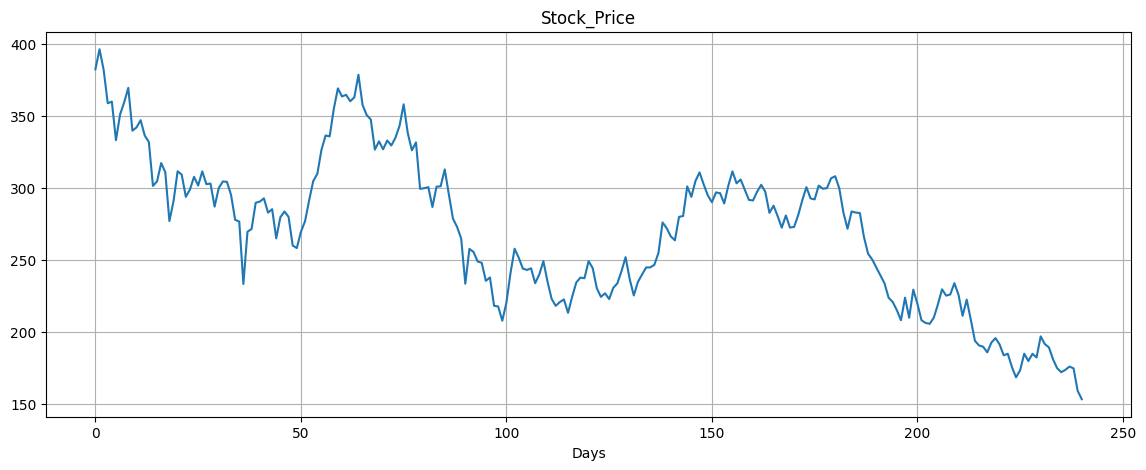

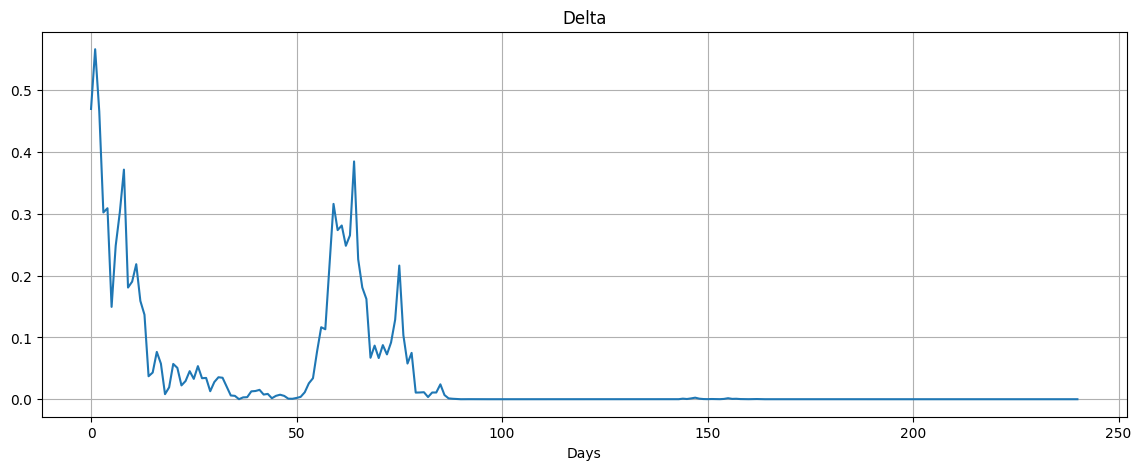

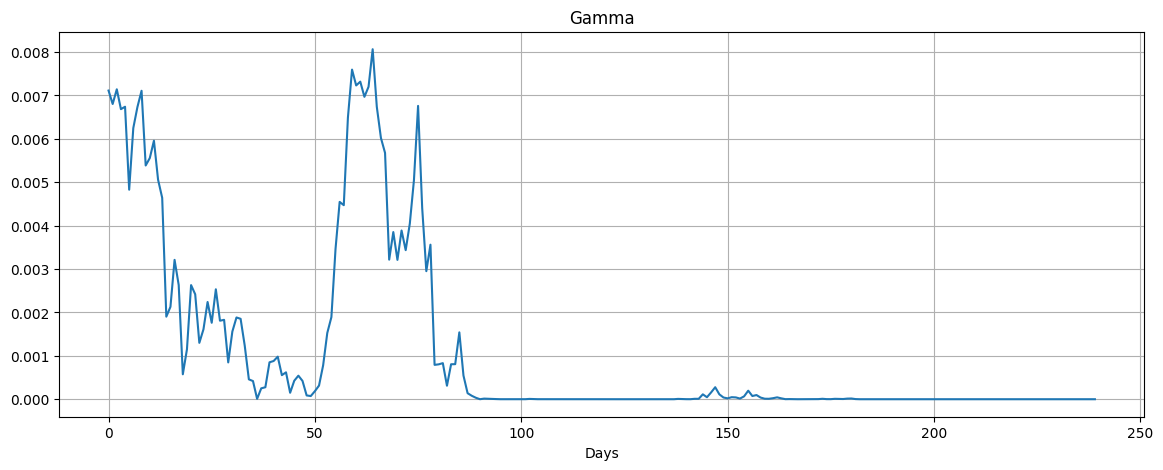

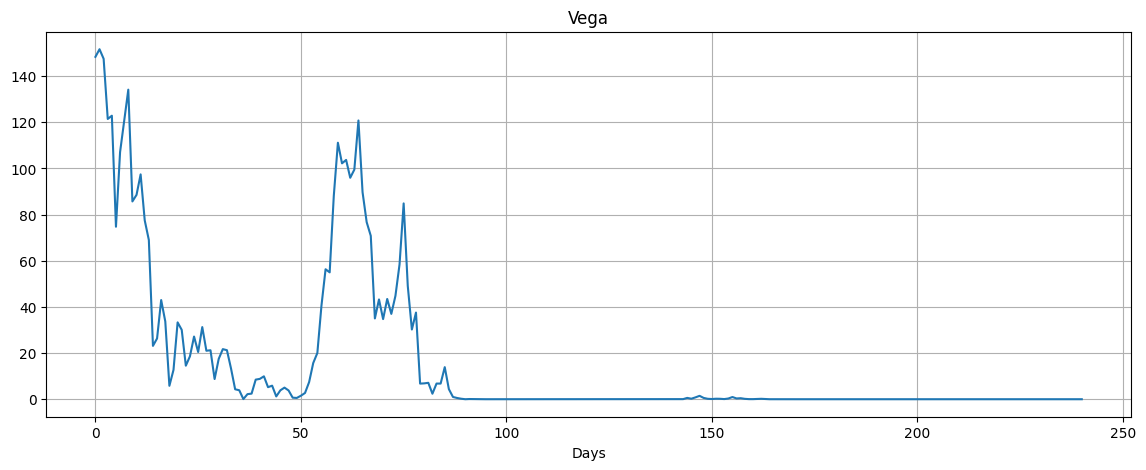

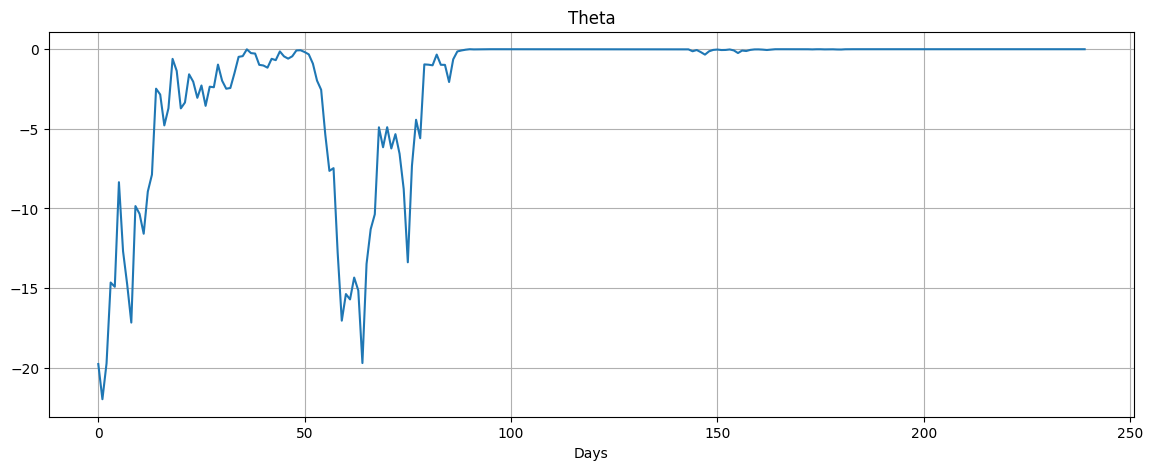

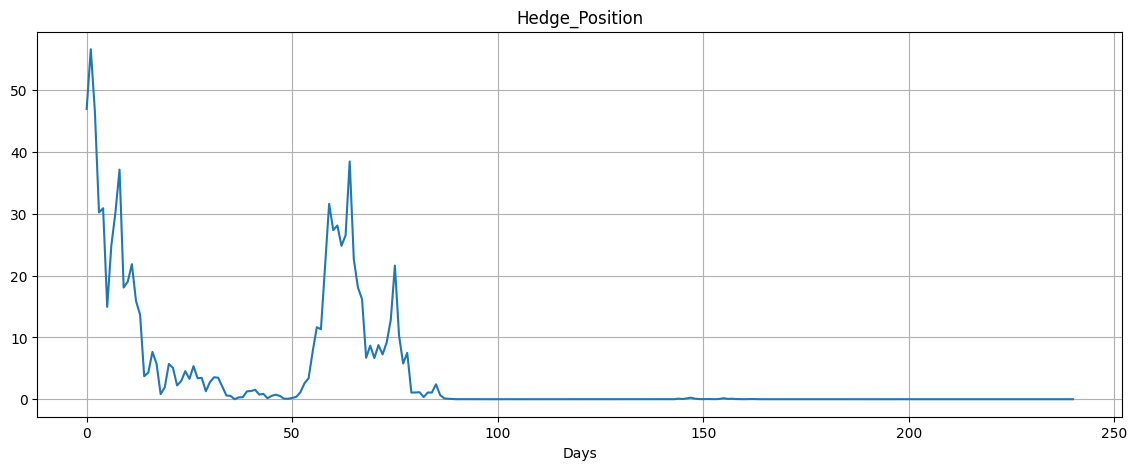

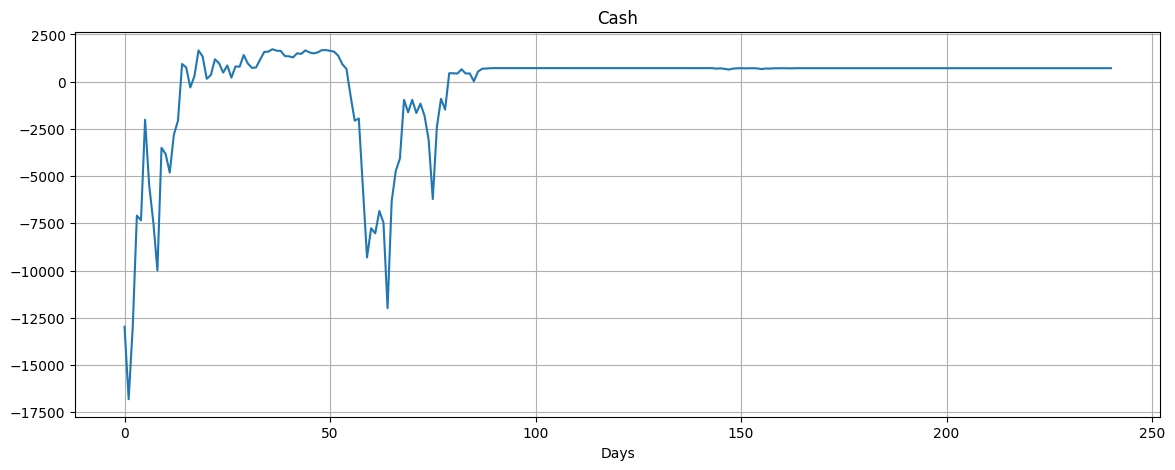

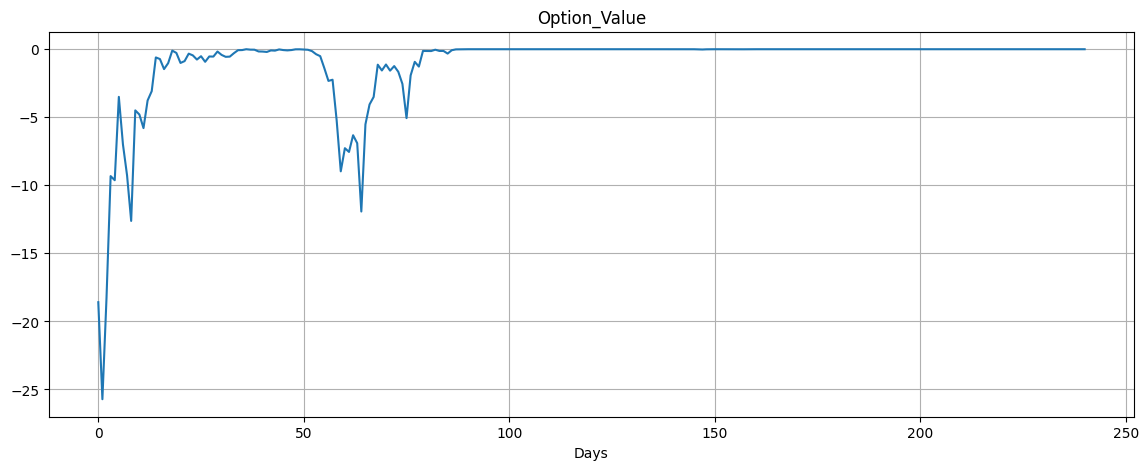

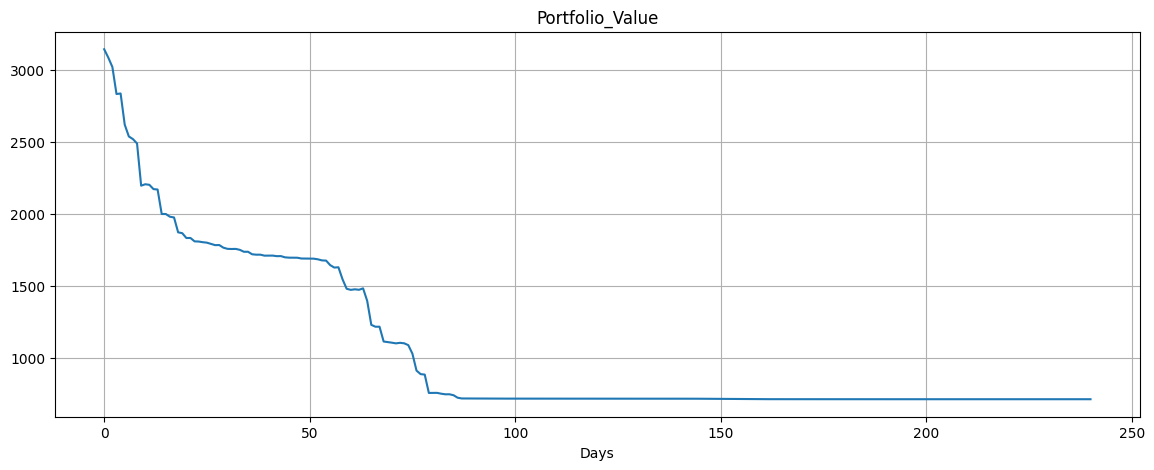

In [22]:
for i in ls:
    plot(result,i)

# Buy Put and Buy Stock

Option Parameters

In [30]:
S = 399
K = 410
T = 1.05
sigma = 0.2
market_price= 25
option_type='put'

In [31]:
max_row=pd.DataFrame(columns=['Date','S','K','T','iv','market_price','option_type'])
max_row.loc[0] = ['2022-01-03', S, K, T, sigma,market_price,option_type]
theo_price, misprice=compute_theoretical_and_mispricing(max_row.iloc[0],0.05)
max_row['theo_price']=theo_price
max_row['misprice']=misprice

In [32]:
max_row

,Date,S,K,T,iv,market_price,option_type,theo_price,misprice
0,2022-01-03,399,410,1.05,0.2,25,put,27.417016,2.417016


In [33]:
option_date = pd.to_datetime(max_row['Date'])
days_to_expiry = int(max_row['T'] * 365)
expiry_date = option_date + timedelta(days=days_to_expiry)
expiry_date

0   2023-01-21
Name: Date, dtype: datetime64[ns]

In [36]:
option_type = 'put'
quantity = 100 
K = max_row['K'].iloc[0]         
T0 = max_row['T'].iloc[0]          
sigma = max_row['iv'].iloc[0]      
entry_price = max_row['market_price'].iloc[0]  
r = 0.05 # Risk-free rate

# Stock data
stock_prices = data.copy().reset_index()
stock_prices = stock_prices.sort_values('Date')
start_date = '2022-01-03'
end_date = '2023-01-21'
stock_prices = stock_prices[
    (stock_prices['Date'] >= start_date) & (stock_prices['Date'] <= end_date)
].copy()
expiry_date = pd.to_datetime('2023-01-21')
stock_prices['T'] = (expiry_date - stock_prices['Date']).dt.days / 365

# Tracking variables
cash_flows = []
stock_held = []
deltas = []
gammas = []
vegas = []
thetas = []
option_values = []
portfolio_values = []
cash = 0

# Day 0
S0 = stock_prices.iloc[0]['Open']
delta0 = delta(S0, K, r, T0, sigma, option_type)
stock_qty = -delta0 * quantity
cash = -entry_price * quantity - stock_qty * S0

# Greeks
gamma0 = gamma(S0, K, r, T0, sigma)
vega0 = vega(S0, K, r, T0, sigma)
theta0 = theta(S0, K, r, T0, sigma, option_type)

# Option value
option_val = bs_price(S0,K,r,T0,sigma,'put')

# Record
cash_flows.append(cash)
stock_held.append(stock_qty)
deltas.append(delta0)
gammas.append(gamma0)
vegas.append(vega0)
thetas.append(theta0)
option_values.append(option_val)
portfolio_values.append(option_val * quantity + stock_qty * S0 + cash)

# Daily Rebalancing
for i in range(1, len(stock_prices)):
    row = stock_prices.iloc[i]
    S = row['Open']
    T = row['T']

    new_delta = delta(S, K, r, T, sigma, option_type)
    target_stock = -new_delta * quantity
    rebalance_qty = target_stock - stock_held[-1]
    cash += -rebalance_qty * S
    print(f"Day {i}: Previous stock holding = {stock_held[-1]:.2f}, New required = {target_stock:.2f}, "
          f"Rebalance Qty = {rebalance_qty:.2f}, Cash Change = {rebalance_qty * S:.2f}")
    # Greeks and option valuation
    gamma_val = gamma(S, K, r, T, sigma)
    vega_val = vega(S, K, r, T, sigma)
    theta_val = theta(S, K, r, T, sigma, option_type)
    option_val = bs_price(S,K,r,T,sigma,'put')

    # Log
    stock_held.append(target_stock)
    deltas.append(new_delta)
    gammas.append(gamma_val)
    vegas.append(vega_val)
    thetas.append(theta_val)
    option_values.append(option_val)
    cash_flows.append(cash)
    portfolio_values.append(option_val * quantity + target_stock * S + cash)

# Expiry: Option Value
final_stock_price = stock_prices.iloc[-1]['Open']
final_stock_position = stock_held[-1]
intrinsic_value = max(K - final_stock_price, 0) * quantity

# Close hedge: Sell shares
close_hedge_cashflow = final_stock_position * final_stock_price
print(f"\nFinal Adjustment: Sell {final_stock_position:.2f} shares at {final_stock_price}, "
      f"cash flow = {close_hedge_cashflow:.2f}")
print(f"Option exercised for = {intrinsic_value:.2f}")

# Final cash and P&L
final_cash = intrinsic_value + close_hedge_cashflow
final_pnl = final_cash + cash
print(f"Final Net P&L = {round(final_pnl, 2)}")

# Result DataFrame
results_put = pd.DataFrame({
    'Date': stock_prices['Date'],
    'Stock_Price': stock_prices['Open'],
    'Delta': deltas,
    'Gamma': gammas,
    'Vega': vegas,
    'Theta': thetas,
    'Hedge_Position': stock_held,
    'Cash': cash_flows,
    'Option_Value': option_values,
    'Portfolio_Value': portfolio_values
})

Day 1: Previous stock holding = 49.17, New required = 42.28, Rebalance Qty = -6.88, Cash Change = -2729.67
Day 2: Previous stock holding = 42.28, New required = 49.43, Rebalance Qty = 7.15, Cash Change = 2732.73
Day 3: Previous stock holding = 49.43, New required = 61.55, Rebalance Qty = 12.12, Cash Change = 4352.04
Day 4: Previous stock holding = 61.55, New required = 61.02, Rebalance Qty = -0.53, Cash Change = -192.42
Day 5: Previous stock holding = 61.02, New required = 74.69, Rebalance Qty = 13.67, Cash Change = 4554.97
Day 6: Previous stock holding = 74.69, New required = 65.86, Rebalance Qty = -8.83, Cash Change = -3100.69
Day 7: Previous stock holding = 65.86, New required = 61.54, Rebalance Qty = -4.32, Cash Change = -1553.98
Day 8: Previous stock holding = 61.54, New required = 56.28, Rebalance Qty = -5.26, Cash Change = -1943.23
Day 9: Previous stock holding = 56.28, New required = 71.72, Rebalance Qty = 15.44, Cash Change = 5247.98
Day 10: Previous stock holding = 71.72, New

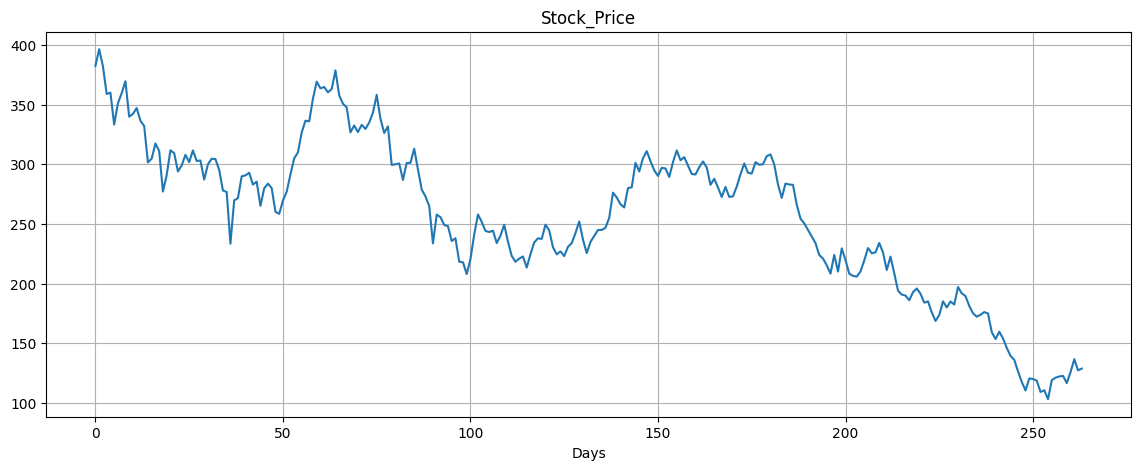

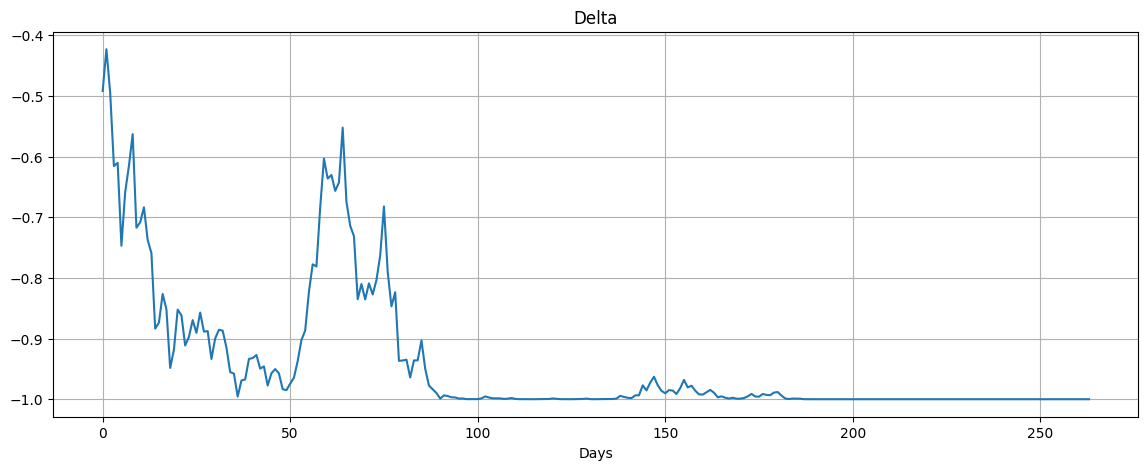

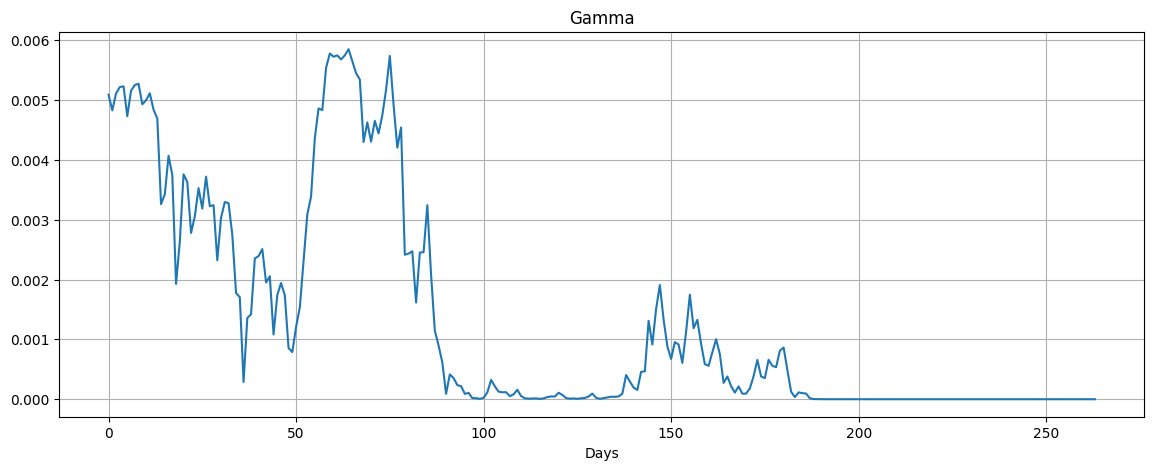

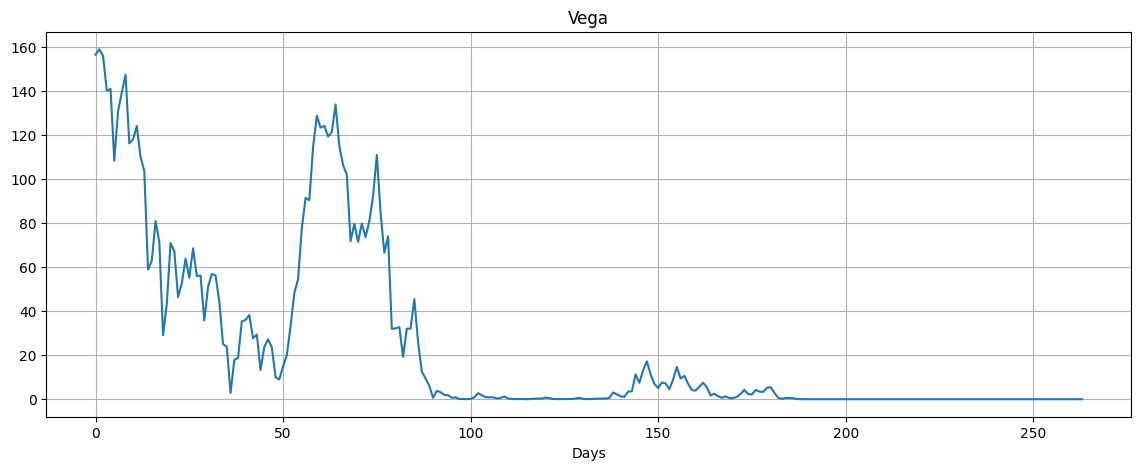

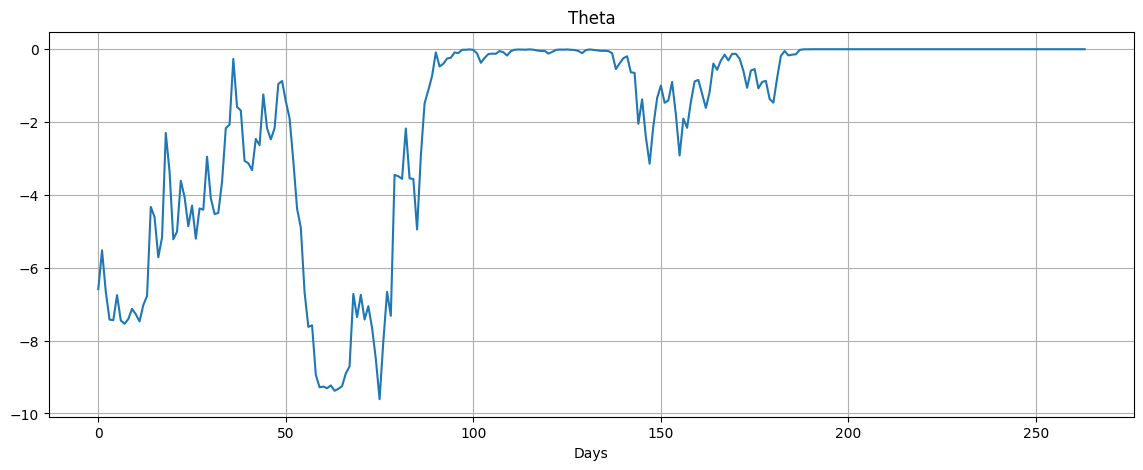

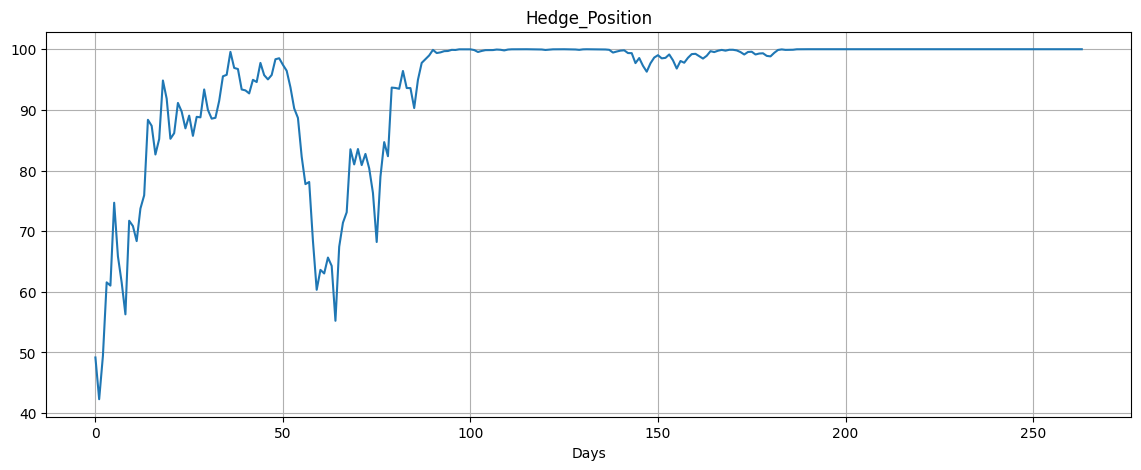

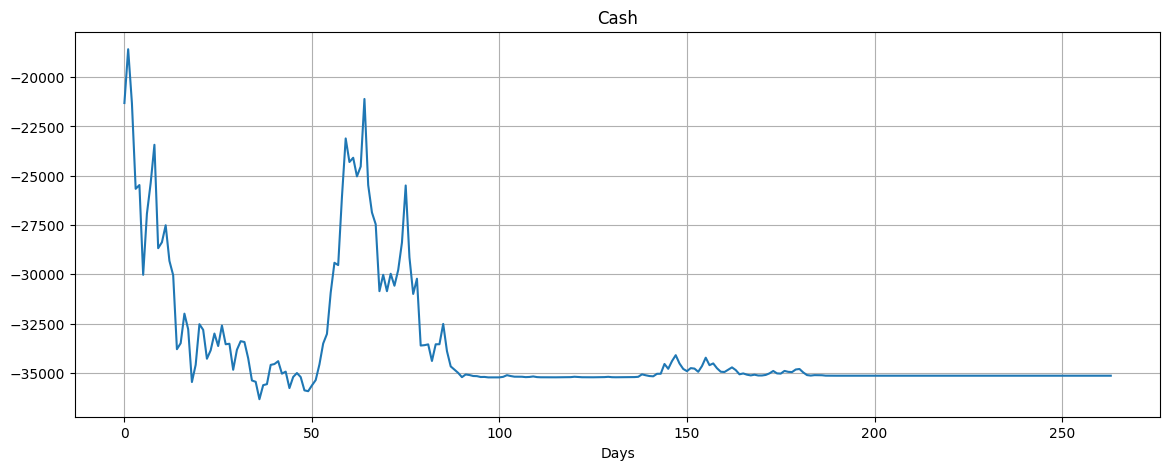

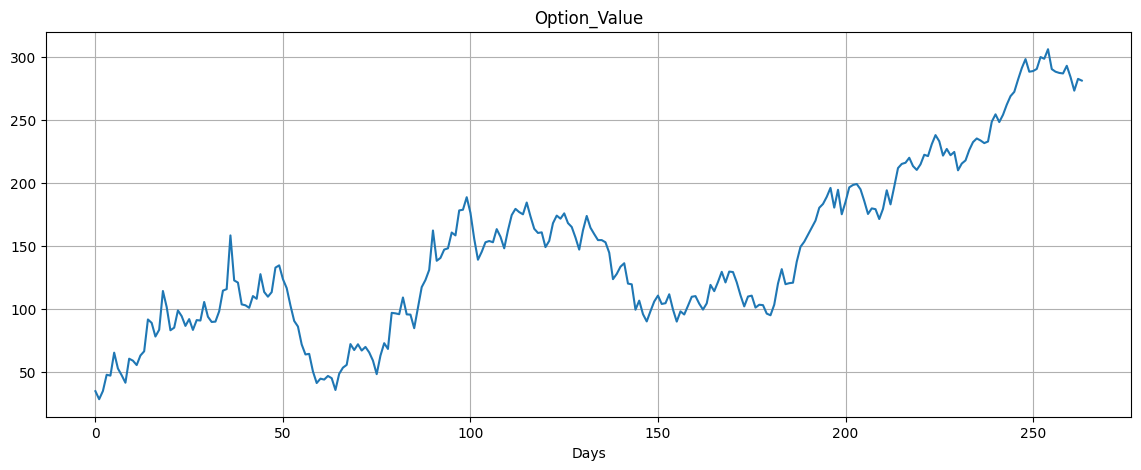

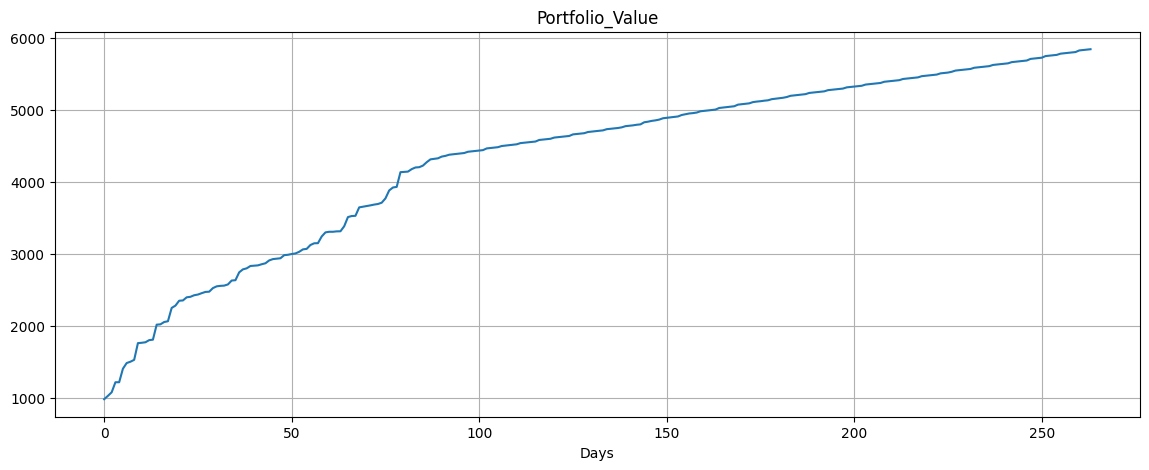

In [37]:
for i in ls:
    plot(results_put,i)

# Sell Put Sell Stock

In [47]:
S = 399
K = 380
T = 1.32
sigma = 0.2
market_price= 25
option_type='put'

In [48]:
min_row=pd.DataFrame(columns=['Date','S','K','T','iv','market_price','option_type'])
min_row.loc[0] = ['2022-01-03', S, K, T, sigma,market_price,option_type]
theo_price, misprice=compute_theoretical_and_mispricing(min_row.iloc[0],0.05)
min_row['theo_price']=theo_price
min_row['misprice']=misprice

In [49]:
min_row

,Date,S,K,T,iv,market_price,option_type,theo_price,misprice
0,2022-01-03,399,380,1.32,0.2,25,put,17.077311,-7.922689


In [41]:
option_date = pd.to_datetime(min_row['Date'])
days_to_expiry = int(min_row['T'] * 365)
expiry_date = option_date + timedelta(days=days_to_expiry)
expiry_date

0   2023-04-29
Name: Date, dtype: datetime64[ns]

In [58]:
option_type = 'put'
quantity = 100 
K = min_row['K'].iloc[0]
T0 = min_row['T'].iloc[0]
sigma = min_row['iv'].iloc[0]
entry_price = min_row['market_price'].iloc[0]
r = 0.05

# Stock data
stock_prices = data.copy().reset_index()
stock_prices = stock_prices.sort_values('Date')
start_date = '2022-01-03'
end_date = '2023-04-29'
stock_prices = stock_prices[
    (stock_prices['Date'] >= start_date) & (stock_prices['Date'] <= end_date)
].copy()
expiry_date = pd.to_datetime('2023-04-29')
stock_prices['T'] = (expiry_date - stock_prices['Date']).dt.days / 365

# Tracking lists
cash_flows = []
stock_held = []
deltas = []
gammas = []
vegas = []
thetas = []
option_values = []
portfolio_values = []

# Day 0: Sell put and hedge
S0 = stock_prices.iloc[0]['Open']
delta0 = delta(S0, K, r, T0, sigma, option_type)
stock_qty = -delta0 * quantity  
cash = entry_price * quantity + stock_qty * S0 

# Greeks and option value
gamma0 = gamma(S0, K, r, T0, sigma)
vega0 = vega(S0, K, r, T0, sigma)
theta0 = theta(S0, K, r, T0, sigma, option_type)
option_val = bs_price(S0,K,r,T0,sigma,'put')

# Record initial state
cash_flows.append(cash)
stock_held.append(stock_qty)
deltas.append(delta0)
gammas.append(gamma0)
vegas.append(vega0)
thetas.append(theta0)
option_values.append(option_val)
portfolio_values.append(-option_val * quantity - stock_qty * S0 + cash)

# Daily rebalancing
for i in range(1, len(stock_prices)):
    row = stock_prices.iloc[i]
    S = row['Open']
    T = row['T']

    new_delta = delta(S, K, r, T, sigma, option_type)
    target_stock = -new_delta * quantity
    rebalance_qty = target_stock - stock_held[-1]
    cash += rebalance_qty * S
    print(f"Day {i}: Previous stock holding = {stock_held[-1]:.2f}, New required = {target_stock:.2f}, "
          f"Rebalance Qty = {rebalance_qty:.2f}, Cash Change = {rebalance_qty * S:.2f}")

    # Greeks and option value
    gamma_val = gamma(S, K, r, T, sigma)
    vega_val = vega(S, K, r, T, sigma)
    theta_val = theta(S, K, r, T, sigma, option_type)
    option_val = bs_price(S,K,r,T,sigma,'put')

    # Logs
    stock_held.append(target_stock)
    deltas.append(new_delta)
    gammas.append(gamma_val)
    vegas.append(vega_val)
    thetas.append(theta_val)
    option_values.append(option_val)
    cash_flows.append(cash)
    portfolio_values.append(-option_val * quantity - target_stock * S + cash)

# Final adjustments at expiry
final_stock_price = stock_prices.iloc[-1]['Open']
final_stock_position = stock_held[-1]

# If exercised
intrinsic_value = max(K - final_stock_price, 0) * quantity

# Sell hedge stock
close_hedge_cashflow = final_stock_position * final_stock_price
print(f"\nFinal Adjustment: Sell {final_stock_position:.2f} shares at {final_stock_price}, "
      f"cash flow = {close_hedge_cashflow:.2f}")
print(f"Option payout (loss) = -{intrinsic_value:.2f}")

# Final cash and P&L
final_cash = -intrinsic_value - close_hedge_cashflow
final_pnl = final_cash + cash
print(f"Final Net P&L = {round(final_pnl, 2)}")

# Save results
result_short_put = pd.DataFrame({
    'Date': stock_prices['Date'],
    'Stock_Price': stock_prices['Open'],
    'Delta': deltas,
    'Gamma': gammas,
    'Vega': vegas,
    'Theta': thetas,
    'Hedge_Position': stock_held,
    'Cash': cash_flows,
    'Option_Value': option_values,
    'Portfolio_Value': portfolio_values
})


Day 1: Previous stock holding = 33.30, New required = 27.86, Rebalance Qty = -5.44, Cash Change = -2156.94
Day 2: Previous stock holding = 27.86, New required = 33.49, Rebalance Qty = 5.63, Cash Change = 2151.38
Day 3: Previous stock holding = 33.49, New required = 43.95, Rebalance Qty = 10.46, Cash Change = 3755.79
Day 4: Previous stock holding = 43.95, New required = 43.44, Rebalance Qty = -0.51, Cash Change = -183.64
Day 5: Previous stock holding = 43.44, New required = 56.99, Rebalance Qty = 13.55, Cash Change = 4515.06
Day 6: Previous stock holding = 56.99, New required = 47.91, Rebalance Qty = -9.08, Cash Change = -3189.99
Day 7: Previous stock holding = 47.91, New required = 43.82, Rebalance Qty = -4.09, Cash Change = -1470.99
Day 8: Previous stock holding = 43.82, New required = 39.11, Rebalance Qty = -4.71, Cash Change = -1740.63
Day 9: Previous stock holding = 39.11, New required = 53.72, Rebalance Qty = 14.61, Cash Change = 4968.41
Day 10: Previous stock holding = 53.72, New

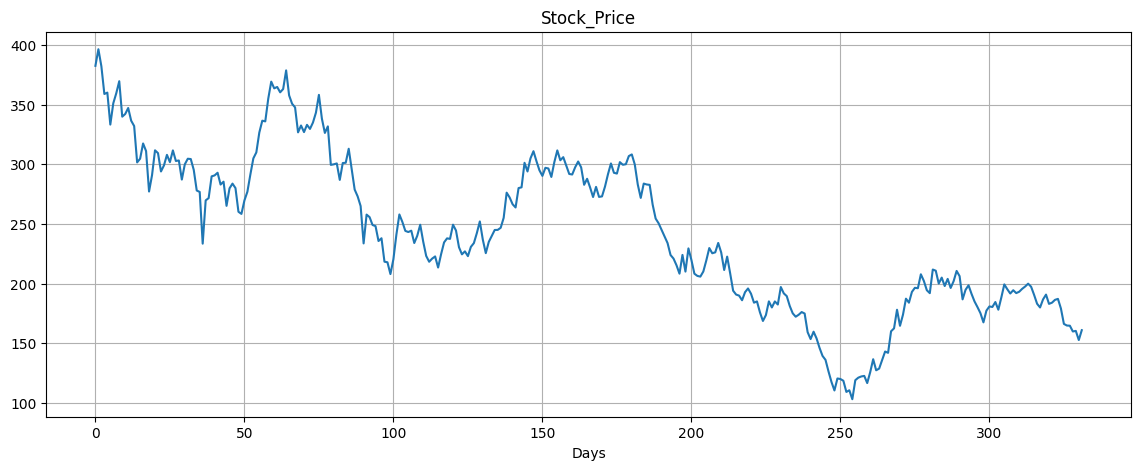

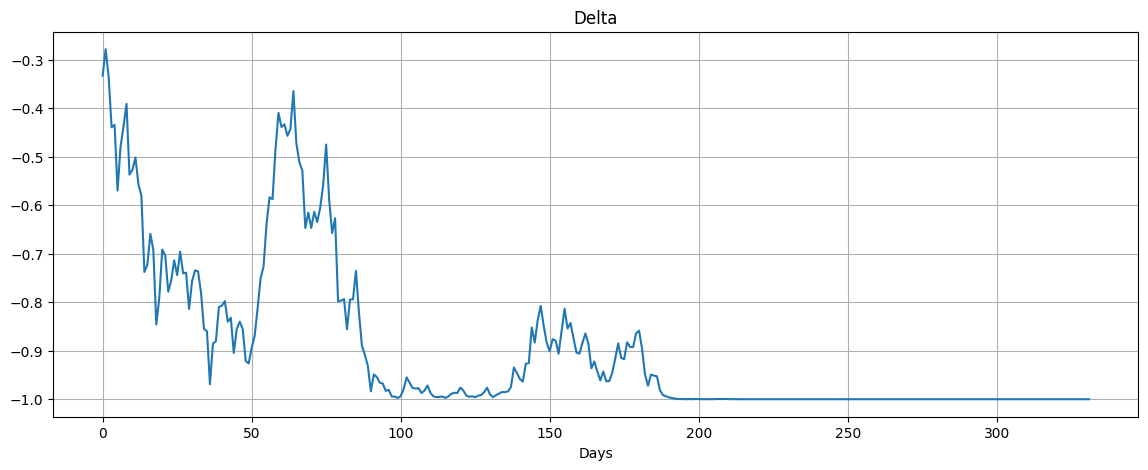

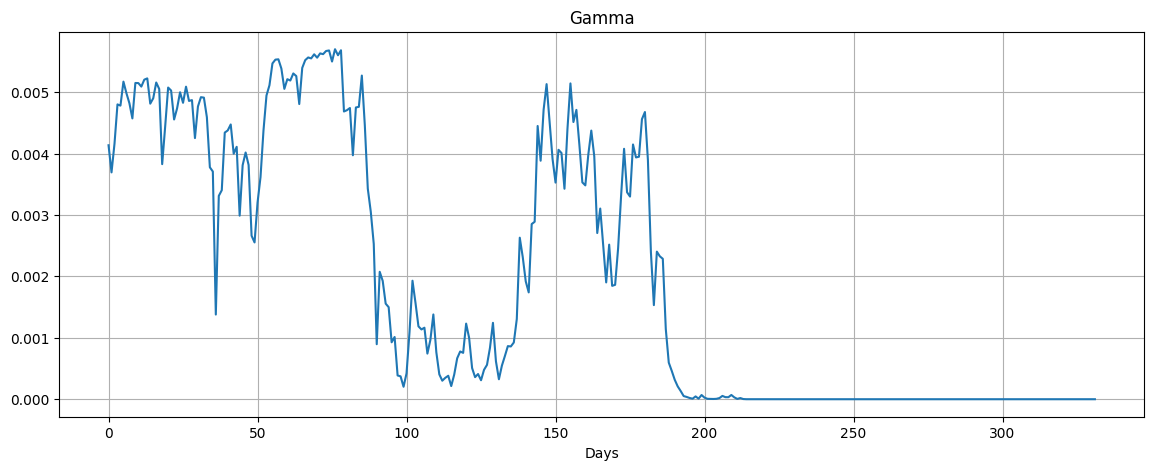

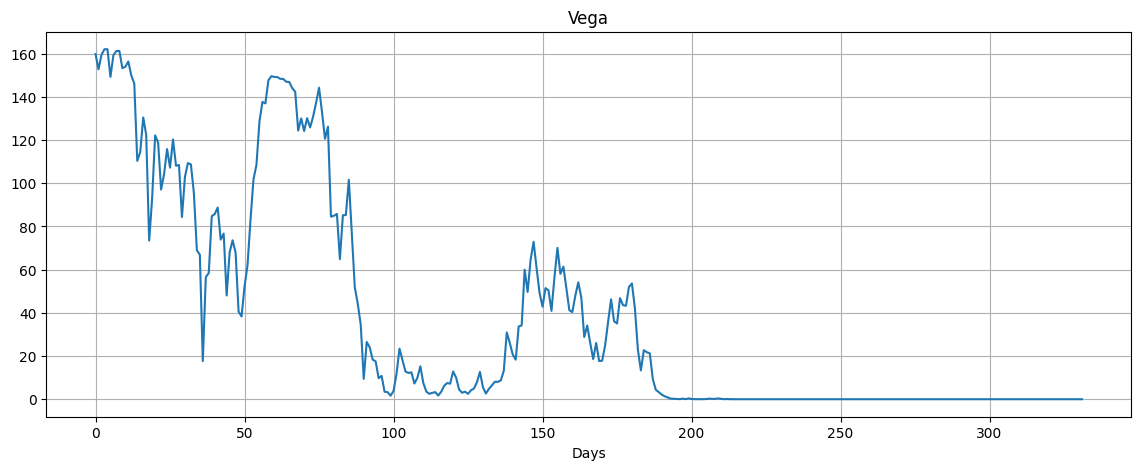

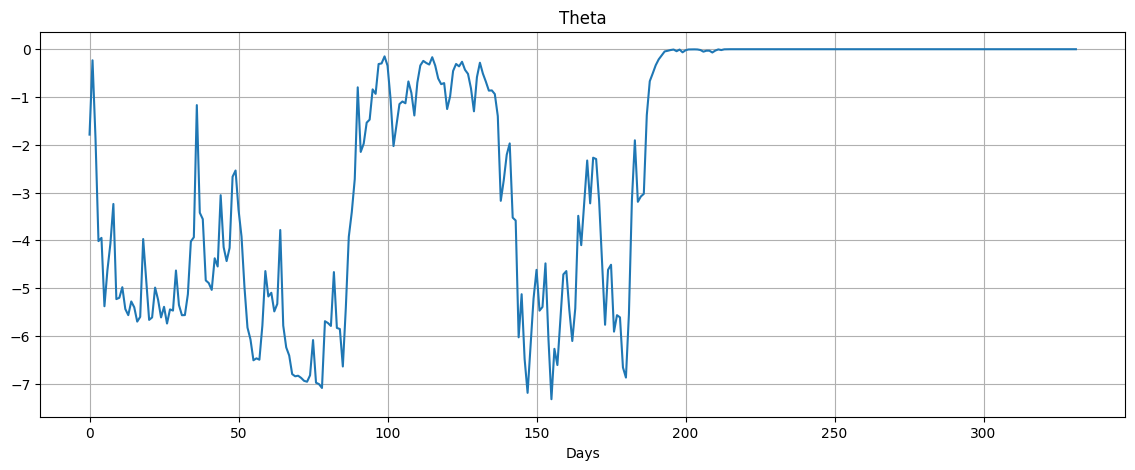

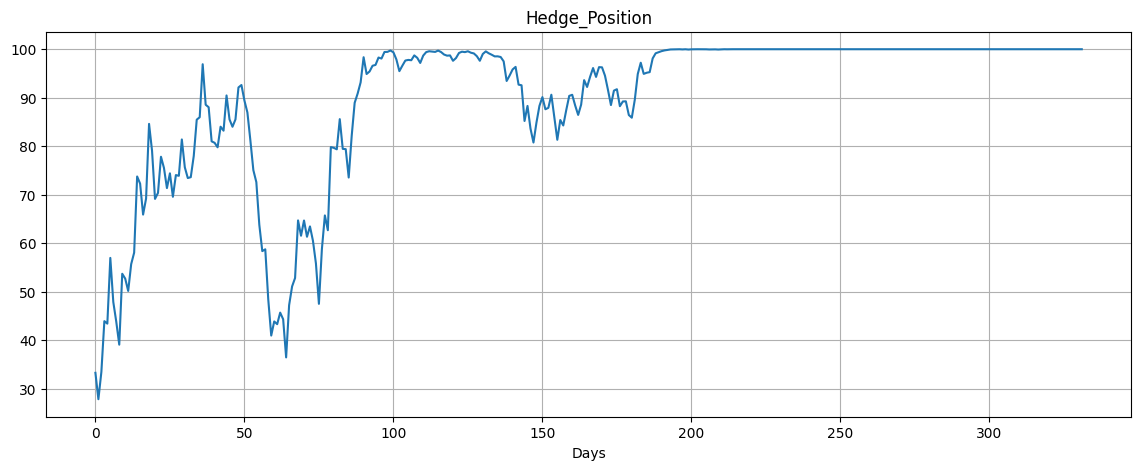

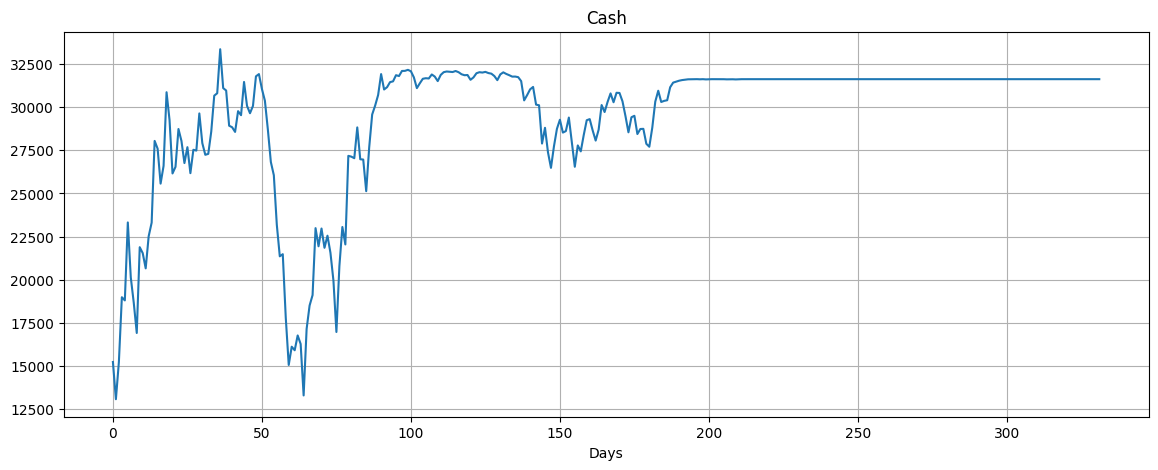

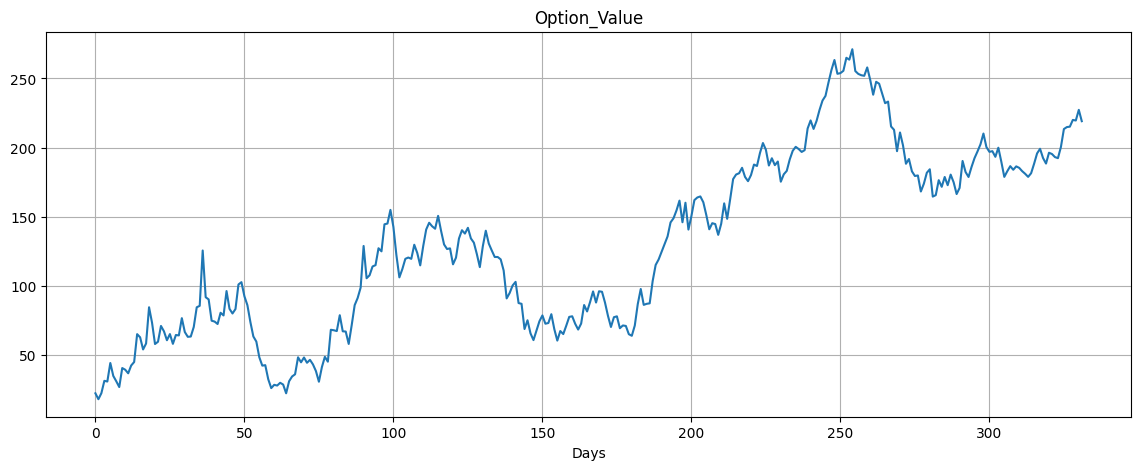

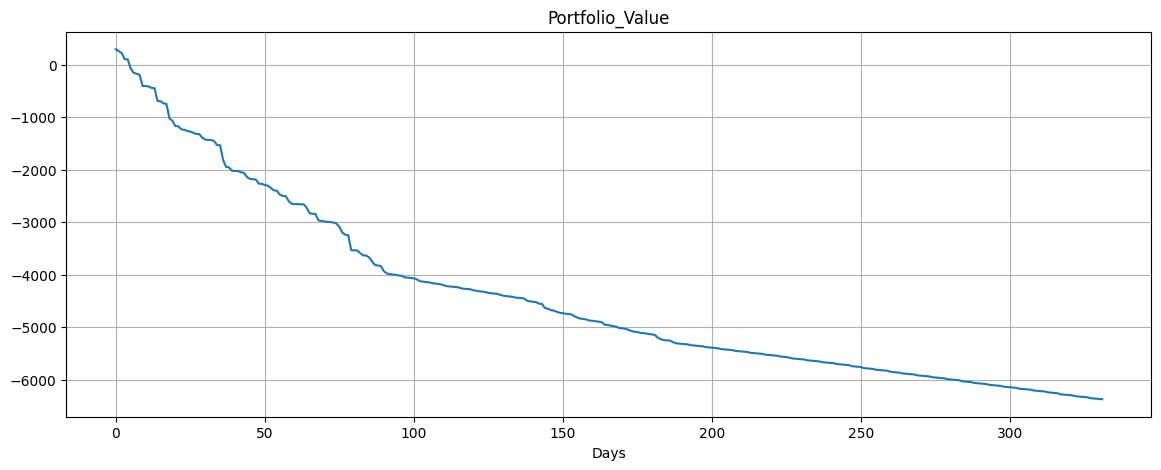

In [59]:
for i in ls:
    plot(result_short_put,i)